# K-fold 수정

- 기존에는 전체 데이터를 10-fold로 나누고 하나는 테스트, 하나는 검정, 나머지는 훈련에 사용

- 수정된 버전의 경우 전체 데이터에서 테스트 데이터를 먼저 분리한 후 나머지 데이터를 k-fold 하도록 변경

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import resnet50
import torch.optim as optim

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from collections import defaultdict

from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, train_test_split, GroupShuffleSplit
import re
import time

/home/hds_lab/anaconda3/envs/yongsik_pdc/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [53]:
preproc_method = 'asr'
preproc_method_for_save = 'asr'
image_trans_method = 'GAF'
segment = 4
overlap = 0

fold_num = 10
batch_size = 32

model_name = 'resnet50'

rs_for_test_split = 512
rs_for_train_split = 123

valid_result_save_path = f'../../../results2/valid_19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol({model_name}, , rs:{rs_for_test_split}).csv'
test_result_save_path = f'../../../results2/test_19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol({model_name}, , rs:{rs_for_test_split}).csv'

## 1. 데이터 불러오기

In [4]:
data_dir = f'../../../images2/{preproc_method}/{image_trans_method}/19ch_{image_trans_method}_{segment}s_{overlap}s_ol_fold'

In [5]:
data_dir

'../../../images2/asr/GAF/19ch_GAF_4s_0s_ol_fold'

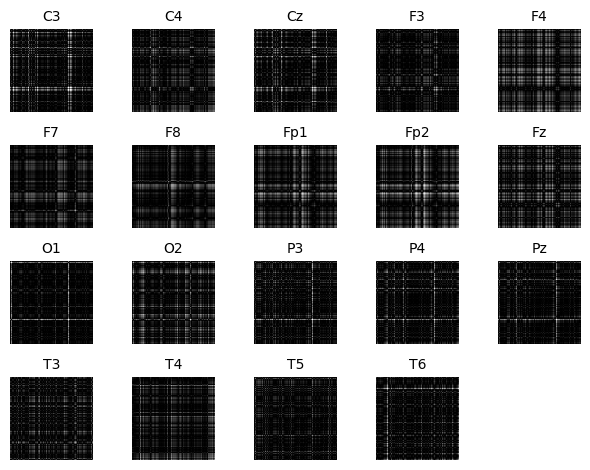

In [6]:
# 데이터 확인
temp_image = np.load(os.path.join(data_dir, 'H S1 EC_001th_window.npy'), allow_pickle=True).astype(np.float32)
channel_name = ['C3', 'C4', 'Cz', 'F3', 'F4',
                'F7', 'F8', 'Fp1', 'Fp2', 'Fz',
                'O1', 'O2', 'P3', 'P4', 'Pz',
                'T3', 'T4', 'T5', 'T6']

for i in range(19):
    plt.subplot(4, 5, i+1)
    plt.imshow(temp_image[i,:,:], cmap='gray')
    plt.gca().set_title(channel_name[i], fontsize=10)
    plt.axis('off')
    plt.tight_layout(h_pad=1, w_pad=1)
plt.show()

In [7]:
temp_image.shape

(19, 224, 224)

## 2. 커스텀 데이터셋 클래스 정의

- 데이터 리사이즈 -> 저장 -> 훈련일 경우 평균, 표준편차 계산 -> 정규화

In [9]:
class NumpyDataset(Dataset):
    def __init__(self, root_dir, fold=0, num_folds=10, mode='train', transform=None, target_size=(224, 224), test_size=0.2, test_random_state=1, train_random_state=1):
        self.root_dir = root_dir
        self.fold = fold
        self.num_folds = num_folds
        self.mode = mode
        self.transform = transform
        self.target_size = target_size
        self.test_size = test_size
        self.test_random_state = test_random_state
        self.train_random_state = train_random_state
        self.classes, self.class_to_idx = self._find_classes()
        self.dataset = self._make_dataset()
        self.mean, self.std = self._compute_stats()

    def _find_classes(self):
        classes = set()
        for fname in os.listdir(self.root_dir):
            if fname.endswith('.npy'):
                class_name = fname.split()[0]
                classes.add(class_name)
        classes = sorted(list(classes)) 
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)} # H, MDD 순서로 정렬되므로 H:0, MDD:1
        return classes, class_to_idx

    def _make_dataset(self):
        samples = []
        for fname in os.listdir(self.root_dir):
            if fname.endswith('.npy'):
                path = os.path.join(self.root_dir, fname)
                class_name, subject, state, segment = self._parse_filename(fname)
                class_idx = self.class_to_idx[class_name]
                unique_subject_id = f'{class_name}_{subject}'
                samples.append((path, class_idx, unique_subject_id, state, segment))

        X = np.array([s[0] for s in samples])
        y = np.array([s[1] for s in samples])
        groups = np.array([s[2] for s in samples])

        # StratifiedGroupKFold를 사용하여 테스트 세트 분리
        sgkf_test = StratifiedGroupKFold(n_splits=int(1/self.test_size), shuffle=True, random_state=self.test_random_state)
        train_val_indices, test_indices = next(sgkf_test.split(X, y, groups))

        train_val_samples = [samples[i] for i in train_val_indices]
        test_samples = [samples[i] for i in test_indices]

        if self.mode == 'test':
            return test_samples

        if self.mode == 'all':
            return train_val_samples

        # 훈련 및 검증 데이터에 대해 다시 StratifiedGroupKFold 수행
        X_train_val = np.array([s[0] for s in train_val_samples])
        y_train_val = np.array([s[1] for s in train_val_samples])
        groups_train_val = np.array([s[2] for s in train_val_samples])

        sgkf = StratifiedGroupKFold(n_splits=self.num_folds, shuffle=True, random_state=self.train_random_state)
        splits = list(sgkf.split(X_train_val, y_train_val, groups_train_val))

        if self.mode == 'train':
            train_indices = splits[self.fold][0]
            return [train_val_samples[i] for i in train_indices]
        elif self.mode == 'valid':
            valid_indices = splits[self.fold][1]
            return [train_val_samples[i] for i in valid_indices]
        else:
            raise ValueError(f"Invalid mode: {self.mode}")
        
    def _parse_filename(self, fname):
        match = re.match(r'(\w+)\s+S(\d+)\s+(\w+)_(\d+)th_window\.npy', fname)
        if match:
            return match.group(1), int(match.group(2)), match.group(3), int(match.group(4))
        else:
            raise ValueError(f"Couldn't parse filename: {fname}")

    def _compute_stats(self):
        if self.mode == 'train':
            channel_sum = np.zeros(19)
            channel_sum_sq = np.zeros(19)
            pixel_count = 0

            for img_path, _, _, _, _ in self.dataset:
                img_array = np.load(img_path, allow_pickle=True).astype(np.float32)
                img_array = self._resize_image(img_array)
                
                channel_sum += img_array.sum(axis=(1, 2))
                channel_sum_sq += (img_array ** 2).sum(axis=(1, 2))
                pixel_count += img_array.shape[1] * img_array.shape[2]

            channel_mean = channel_sum / pixel_count
            channel_std = np.sqrt(channel_sum_sq / pixel_count - channel_mean ** 2)

            NumpyDataset.train_mean = channel_mean
            NumpyDataset.train_std = channel_std
        else:
            if not hasattr(NumpyDataset, 'train_mean') or not hasattr(NumpyDataset, 'train_std'):
                raise ValueError("Train statistics not computed. Please initialize train dataset first.")
            channel_mean = NumpyDataset.train_mean
            channel_std = NumpyDataset.train_std

        return channel_mean, channel_std

    def _resize_image(self, img):
        # NumPy 배열을 PyTorch 텐서로 변환
        img_tensor = torch.from_numpy(img)
        # 리사이즈 수행
        resized_img = transforms.Resize(self.target_size)(img_tensor)
        # 다시 NumPy 배열로 변환
        return resized_img.numpy()

    def _normalize_image(self, img):
        return (img - self.mean[:, None, None]) / self.std[:, None, None]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, class_idx, unique_subject_id, state, segment = self.dataset[idx]
        
        # 이미지 로드
        img = np.load(img_path, allow_pickle=True).astype(np.float32)
        
        # 리사이즈
        img = self._resize_image(img)
        
        # 정규화
        img = self._normalize_image(img)
        
        # NumPy 배열을 PyTorch 텐서로 변환
        img = torch.from_numpy(img).float()
        
        if self.transform:
            img = self.transform(img)
        
        return img, class_idx, unique_subject_id, state, segment

## 3. 훈련 함수 정의

In [54]:
# 모델 입력에 NaN / Inf 값이 있는지 확인하는 함수
def check_nan_inf(tensor, name='Tensor'):
    if torch.isnan(tensor).any():
        print(f'{name} contains NaN values.')
    if torch.isinf(tensor).any():
        print(f'{name} contains Inf values.')

In [55]:
def train_model(model, train_loader, valid_loader,
                criterion, optimizer, device, scheduler=None,
                epochs=100, max_norm=1.0, early_stopping_epochs=10, delta=0, 
                save_path=None,
                abnomaly_detect=False):
    """
    모델 학습 및 검증을 수행하는 함수

    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        valid_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 옵티마이저
        scheduler: 학습률 스케줄러
        device: 모델이 사용할 디바이스 (ex. 'cuda' or 'cpu')
        epochs: 총 학습 에포크 수
        max_norm: 그래디언트 클리핑을 위한 최대 노름 값
        early_stopping_epochs: 조기 종료를 위한 에포크 수
        delta: 조기 종료를 위한 최소 변화값
        save_path: 모델을 저장할 경로 (기본값: None)

    Returns:
        history: 훈련 및 검증 손실과 정확도를 기록한 딕셔너리
    """

    torch.cuda.empty_cache()    
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    best_loss = float('inf')
    early_stop_counter = 0

    for e in range(epochs):
        torch.autograd.set_detect_anomaly(abnomaly_detect)
        # training loop
        running_loss = 0
        running_accuracy = 0
        model.train()
        print('='*80)
        for X, Y, *_ in tqdm(train_loader, desc=f'Epoch {e+1:3d}/{epochs}'):
            check_nan_inf(X, 'Input X')
            check_nan_inf(Y, 'Input Y')

            X = X.to(device).float()
            Y = Y.to(device).long()
            
            optimizer.zero_grad()
            
            outputs = model(X)
            check_nan_inf(outputs, 'Model outputs')
                
            loss = criterion(outputs, Y)
            check_nan_inf(loss, 'Loss')   
            loss.backward()
            
            # 그래디언트 클리핑
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_accuracy += torch.sum(preds == Y).float().item() / X.size(0)
        
        # validation loop
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for X, Y, *_ in tqdm(valid_loader, desc='Validation   '):
                check_nan_inf(X, 'Input X')
                check_nan_inf(Y, 'Input Y')

                X = X.to(device).float()
                Y = Y.to(device).long()

                outputs = model(X)
                check_nan_inf(outputs, 'Model outputs')

                loss = criterion(outputs, Y)
                check_nan_inf(loss, 'Loss')

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item()
                val_accuracy += torch.sum(preds == Y).float().item() / X.size(0)
        
        if scheduler:
            scheduler.step(val_loss)

        # calculate mean for each batch
        current_lr = optimizer.param_groups[0]['lr']
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(valid_loader))
        train_acc.append(running_accuracy / len(train_loader))
        val_acc.append(val_accuracy / len(valid_loader))
        print('-'*80)
        print(f"Epoch:{e+1}/{epochs}..", "\n",
              f"Train Loss: {running_loss / len(train_loader):.3f}..",
              f"Val Loss: {val_loss / len(valid_loader):.3f}..", "\n",
              f"Train Acc : {running_accuracy / len(train_loader):.3f}..",
              f"Val Acc : {val_accuracy / len(valid_loader):.3f}..", "\n",
              f"Learning Rate : {current_lr}"
              )
        print('='*80, '\n')
        
        # early stopping
        if val_loss / len(valid_loader) > best_loss - delta:
            early_stop_counter += 1
        else:
            if save_path is not None:
                torch.save(model.state_dict(), save_path)
            
            best_loss = val_loss / len(valid_loader)
            early_stop_counter = 0

        if early_stop_counter >= early_stopping_epochs:
            print(f'Early stopping at epoch {e+1}')
            break

    history = {'train_loss': train_losses, 'val_loss': val_losses,
                'train_acc': train_acc, 'val_acc': val_acc}
    
    return history

## 4. 결과 계산 및 저장 함수

In [12]:
def cal_metrics(conf_mat, digit=4):
    tn, fp, fn, tp = conf_mat.ravel()
    accuracy = round((tp + tn) / (tp + tn + fp + fn), digit)
    sensitivity = round(tp / (tp + fn), digit)
    specificity = round(tn / (tn + fp), digit)
    precision = round(tp / (tp + fp), digit)
    f1 = round(2 * (precision * sensitivity) / (precision + sensitivity), digit)

    return accuracy, sensitivity, specificity, precision, f1

In [56]:
def write_result(result_path, fold, met, load_time=0, train_time=0):
    if not os.path.exists(result_path):
        f = open(result_path, 'w')
        txt = 'Fold,acc,sn,sp,prec,f1,data loader time,training time\n'
        f.write(txt)
        f.close()

    f = open(result_path, 'a')
    txt = f'{fold},{met[0]},{met[1]},{met[2]},{met[3]},{met[4]},{load_time},{train_time}\n'
    f.write(txt)
    f.close()

In [57]:
def cal_sens_spec(conf_mat):
    tn, fp, fn, tp = conf_mat.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

## 5. 피험자별 세그먼트 예측 계산

In [58]:
def analyze_predictions_by_id(y_true, y_pred, unq_ids, states):
    # 각 unq_id에 대한 예측 성공/실패 횟수를 저장할 딕셔너리 초기화
    results = defaultdict(lambda: {'correct': 0, 'incorrect': 0, 'total': 0})
    
    # 각 예측에 대해 반복
    for true, pred, unq_id, state in zip(y_true, y_pred, unq_ids, states):
        # 해당 unq_id의 총 예측 횟수 증가
        key = f'{unq_id}_{state}'
        results[key]['total'] += 1
        
        # 예측이 맞았는지 확인하고 적절한 카운터 증가
        if true == pred:
            results[key]['correct'] += 1
        else:
            results[key]['incorrect'] += 1
    
    # 각 unq_id에 대한 정확도 계산
    for key in results:
        total = results[key]['total']
        correct = results[key]['correct']
        results[key]['accuracy'] = correct / total if total > 0 else 0
    
    return dict(results)  # defaultdict를 일반 딕셔너리로 변환하여 반환

In [59]:
def generate_labels(data_dict):
    true_labels = []
    predicted_labels = []
    
    for key, value in data_dict.items():
        # 실제 label 결정
        if 'MDD' in key:
            true_label = 1
        elif 'H' in key:
            true_label = 0
        else:
            continue  # MDD나 H가 없는 키는 무시
        
        # 예측 label 결정
        accuracy = value['accuracy']
        if accuracy > 0.5:
            predicted_label = true_label
        else:
            predicted_label = 1 - true_label  # 반대 레이블
        
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    
    return true_labels, predicted_labels

## Fold : 1

In [62]:
fold_idx = 0

### 1) 데이터셋 및 데이터로더 생성

In [16]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [17]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [18]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [19]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


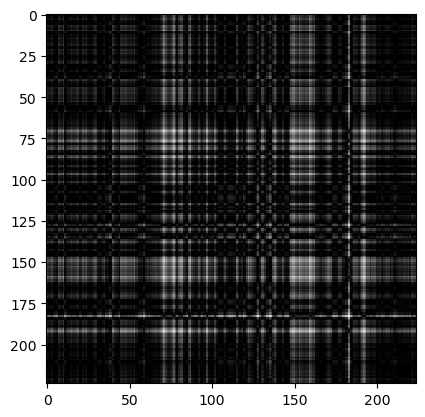

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [20]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [21]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [22]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [23]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [24]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [50]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [26]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [60]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [61]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [28]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [29]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [30]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [31]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 2

In [ ]:
fold_idx = 1

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


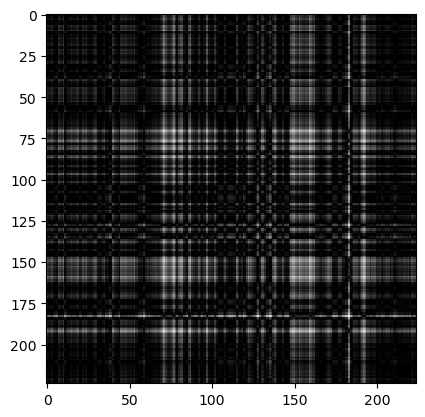

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 3

In [ ]:
fold_idx = 2

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


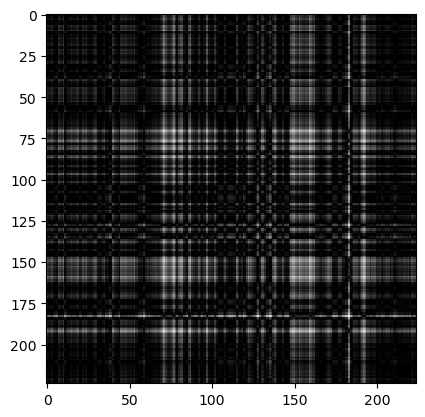

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 4

In [ ]:
fold_idx = 3

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


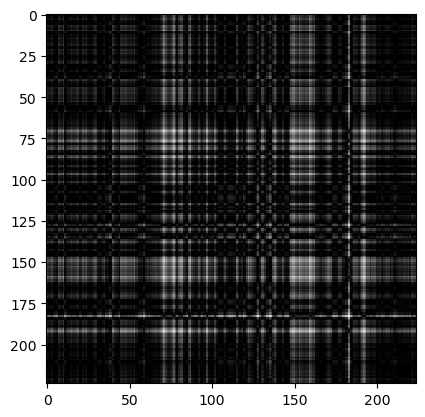

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 5

In [ ]:
fold_idx = 4

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


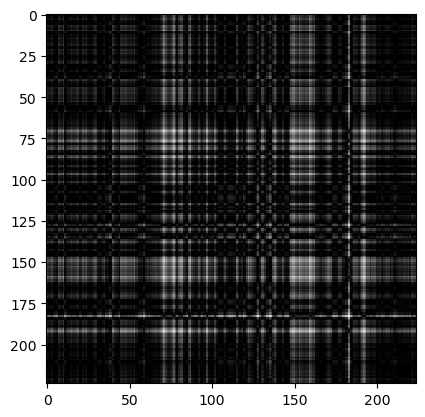

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 6

In [ ]:
fold_idx = 5

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


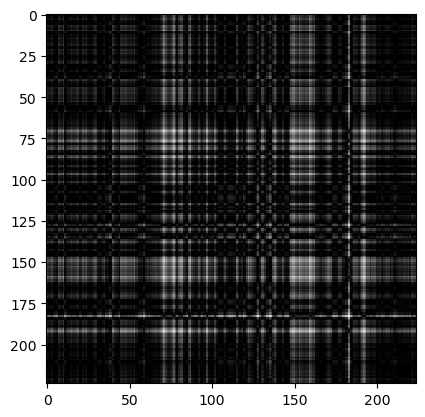

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 7

In [ ]:
fold_idx = 6

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


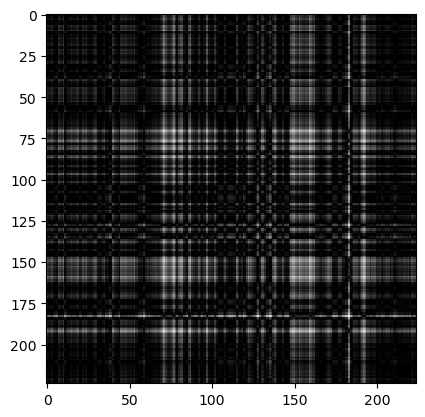

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 8

In [ ]:
fold_idx = 7

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


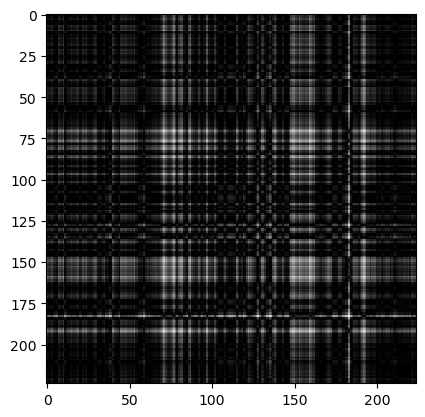

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 9

In [ ]:
fold_idx = 8

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


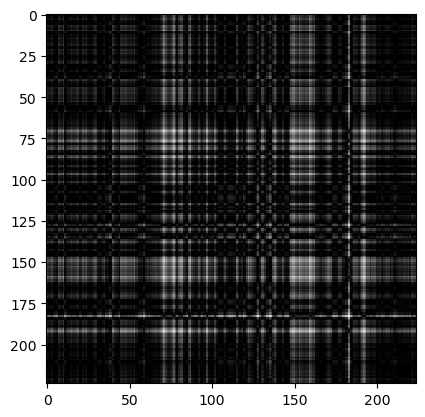

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()

## Fold : 10

In [ ]:
fold_idx = 9

### 1) 데이터셋 및 데이터로더 생성

In [ ]:
start_time = time.time()
train_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='train', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
valid_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='valid', transform=None, target_size=(224, 224),
                             test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)
test_dataset = NumpyDataset(data_dir, fold=fold_idx, num_folds=fold_num, mode='test', transform=None, target_size=(224, 224),
                            test_size=0.2, test_random_state=rs_for_test_split, train_random_state=rs_for_train_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=True, persistent_workers=True)
end_time = time.time()

ex_time = end_time - start_time
loader_time = f'{int(ex_time // 60)}:{int(ex_time % 60)}'

In [ ]:
train_labels = [sam[1] for sam in train_dataset.dataset]
valid_labels = [sam[1] for sam in valid_dataset.dataset]
test_labels = [sam[1] for sam in test_dataset.dataset]

train_group = [sam[2] for sam in train_dataset.dataset]
valid_group = [sam[2] for sam in valid_dataset.dataset]
test_group = [sam[2] for sam in test_dataset.dataset]

In [ ]:
print(sorted(set(valid_group)), '\n', sorted(set(test_group)))

['H_15', 'H_28', 'MDD_23', 'MDD_27', 'MDD_30'] 
 ['H_18', 'H_20', 'H_23', 'H_24', 'H_26', 'H_8', 'MDD_12', 'MDD_14', 'MDD_20', 'MDD_28', 'MDD_4', 'MDD_5', 'MDD_7']


In [ ]:
print(train_labels.count(0), train_labels.count(1))
print(valid_labels.count(0), valid_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

3169 3331
299 435
830 796


#### a) 데이터 확인

Feature batch shape: torch.Size([32, 19, 224, 224])
Labels batch shape: torch.Size([32])


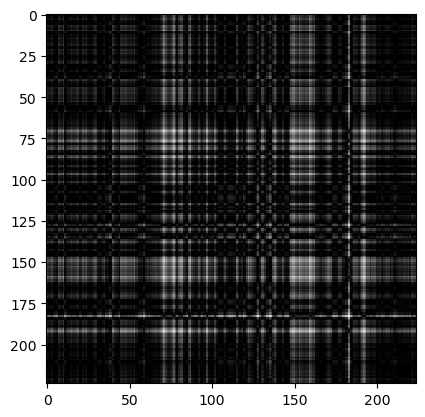

Label: 0
Unique subject ID: H_12
State: EO
Segment: 57


In [ ]:
# 이미지와 레이블을 표시합니다.
train_features, train_labels, unq_sub_ids, states, segments = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}\nUnique subject ID: {unq_sub_ids[0]}\nState: {states[0]}\nSegment: {segments[0]}")

### 2) 모델 설계

#### a) resnet50

In [ ]:
model = resnet50(weights='IMAGENET1K_V2')

#### b) fine tuning

In [ ]:
# 첫 번째 층 fine tuning 및 가중치 초기화
new_channels = 19
with torch.no_grad():
    new_weight = model.conv1.weight.clone()
    model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # 가중치 랜덤 초기화
    nn.init.kaiming_normal_(model.conv1.weight[:, 3:], mode='fan_out', nonlinearity='relu')

# 마지막 층 fine tuning
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

### 3) optimizer

In [ ]:
learning_rate = 5e-4
decay = 1e-2

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=0.9)
# lr 스케쥴러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

### 4) 모델 학습

In [ ]:
start_time = time.time()
history = train_model(model=model,
                      train_loader=train_loader, valid_loader=valid_loader,
                      criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                      device=device,
                      epochs=200, max_norm=1.0, early_stopping_epochs=10, delta=0,
                      save_path=f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth',
                      abnomaly_detect=False)
end_time = time.time()

ex_time = end_time - start_time
train_time = f'{int(ex_time // 60)}:{int(ex_time) % 60}'

Validation   : 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


--------------------------------------------------------------------------------
Epoch:1/200.. 
 Train Loss: 0.686.. Val Loss: 0.656.. 
 Train Acc : 0.555.. Val Acc : 0.694.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


--------------------------------------------------------------------------------
Epoch:2/200.. 
 Train Loss: 0.658.. Val Loss: 0.627.. 
 Train Acc : 0.657.. Val Acc : 0.749.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


--------------------------------------------------------------------------------
Epoch:3/200.. 
 Train Loss: 0.631.. Val Loss: 0.602.. 
 Train Acc : 0.700.. Val Acc : 0.748.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


--------------------------------------------------------------------------------
Epoch:4/200.. 
 Train Loss: 0.602.. Val Loss: 0.569.. 
 Train Acc : 0.723.. Val Acc : 0.757.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  7.70it/s]


--------------------------------------------------------------------------------
Epoch:5/200.. 
 Train Loss: 0.573.. Val Loss: 0.546.. 
 Train Acc : 0.747.. Val Acc : 0.762.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


--------------------------------------------------------------------------------
Epoch:6/200.. 
 Train Loss: 0.543.. Val Loss: 0.532.. 
 Train Acc : 0.770.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]


--------------------------------------------------------------------------------
Epoch:7/200.. 
 Train Loss: 0.516.. Val Loss: 0.528.. 
 Train Acc : 0.781.. Val Acc : 0.752.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.79it/s]


--------------------------------------------------------------------------------
Epoch:8/200.. 
 Train Loss: 0.491.. Val Loss: 0.530.. 
 Train Acc : 0.796.. Val Acc : 0.734.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]


--------------------------------------------------------------------------------
Epoch:9/200.. 
 Train Loss: 0.464.. Val Loss: 0.508.. 
 Train Acc : 0.811.. Val Acc : 0.759.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.41it/s]


--------------------------------------------------------------------------------
Epoch:10/200.. 
 Train Loss: 0.440.. Val Loss: 0.537.. 
 Train Acc : 0.828.. Val Acc : 0.745.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.03it/s]


--------------------------------------------------------------------------------
Epoch:11/200.. 
 Train Loss: 0.419.. Val Loss: 0.558.. 
 Train Acc : 0.839.. Val Acc : 0.727.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.78it/s]


--------------------------------------------------------------------------------
Epoch:12/200.. 
 Train Loss: 0.400.. Val Loss: 0.519.. 
 Train Acc : 0.842.. Val Acc : 0.753.. 
 Learning Rate : 0.0005



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.65it/s]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
--------------------------------------------------------------------------------
Epoch:13/200.. 
 Train Loss: 0.379.. Val Loss: 0.546.. 
 Train Acc : 0.854.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.73it/s]


--------------------------------------------------------------------------------
Epoch:14/200.. 
 Train Loss: 0.365.. Val Loss: 0.515.. 
 Train Acc : 0.862.. Val Acc : 0.753.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.77it/s]


--------------------------------------------------------------------------------
Epoch:15/200.. 
 Train Loss: 0.351.. Val Loss: 0.581.. 
 Train Acc : 0.870.. Val Acc : 0.732.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.83it/s]


--------------------------------------------------------------------------------
Epoch:16/200.. 
 Train Loss: 0.343.. Val Loss: 0.556.. 
 Train Acc : 0.876.. Val Acc : 0.738.. 
 Learning Rate : 0.00025



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.
--------------------------------------------------------------------------------
Epoch:17/200.. 
 Train Loss: 0.333.. Val Loss: 0.606.. 
 Train Acc : 0.883.. Val Acc : 0.726.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  8.59it/s]


--------------------------------------------------------------------------------
Epoch:18/200.. 
 Train Loss: 0.323.. Val Loss: 0.602.. 
 Train Acc : 0.884.. Val Acc : 0.721.. 
 Learning Rate : 0.000125



Validation   : 100%|██████████| 23/23 [00:02<00:00,  9.00it/s]

--------------------------------------------------------------------------------
Epoch:19/200.. 
 Train Loss: 0.325.. Val Loss: 0.576.. 
 Train Acc : 0.882.. Val Acc : 0.734.. 
 Learning Rate : 0.000125

Early stopping at epoch 19


### 5) 모델 테스트

In [ ]:
# 저장된 모델 불러옴
model = resnet50()
new_channels = 19
model.conv1 = nn.Conv2d(new_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
fc_in_ch = model.fc.in_features
model.fc = nn.Linear(fc_in_ch, 2)

model.load_state_dict(torch.load(f'../../../models2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).pth'))
model = model.to(device)

### valid
y_valid_pred = []
y_valid_true = []
unq_ids_valid = []
states_valid = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(valid_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_valid_pred += list(preds.detach().cpu().numpy())
        y_valid_true += list(Y.detach().cpu().numpy())
        unq_ids_valid += unq_id
        states_valid += state

### Test
y_test_pred = []
y_test_true = []
unq_ids_test = []
states_test = []
with torch.no_grad():
    model.eval()
    for X, Y, unq_id, state,_ in tqdm(test_loader):                   
        X = X.to(device).float()
        Y = Y.to(device).long()
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_test_pred += list(preds.detach().cpu().numpy())
        y_test_true += list(Y.detach().cpu().numpy())
        unq_ids_test += unq_id
        states_test += state

100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


In [ ]:
# https://netron.app 으로 모델 구조 간편히 시각화하기 위한 모델 저장
# torch.save(model, '../../models/19ch_GAF_without_noise_reduce_for_arch.pth')

In [ ]:
### valid 예측 리포트
print(f'\nValid Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_valid_true,
      y_valid_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_valid_true, y_valid_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_valid_true, y_valid_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_valid_true, y_valid_pred))
write_result(valid_result_save_path, fold_idx, metrics, loader_time, train_time)


### test 예측 리포트
print(f'\nTest Classification report \n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      y_test_true,
      y_test_pred,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(y_test_true, y_test_pred), '\n')

# 민감도, 특이도 계산
sens, spec = cal_sens_spec(confusion_matrix(y_test_true, y_test_pred))
print('sensitivity :', round(sens, 4))
print('specificity :', round(spec, 4))

metrics = cal_metrics(confusion_matrix(y_test_true, y_test_pred))
write_result(test_result_save_path, fold_idx, metrics, loader_time, train_time)


Valid Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6287    0.9967    0.7710       299
         MDD     0.9962    0.5954    0.7453       435

    accuracy                         0.7589       734
   macro avg     0.8124    0.7960    0.7582       734
weighted avg     0.8465    0.7589    0.7558       734

[[298   1]
 [176 259]] 

sensitivity : 0.5954
specificity : 0.9967

Test Classification report 
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.8370    0.7301    0.7799       830
         MDD     0.7517    0.8518    0.7986       796

    accuracy                         0.7897      1626
   macro avg     0.7943    0.7909    0.7893      1626
weighted avg     0.7952    0.7897    0.7891      1626

[[606 224]
 [118 678]] 

sensitivity : 0.8518
specificity : 0.7301


In [ ]:
# valid
subject_pred = analyze_predictions_by_id(y_valid_true, y_valid_pred, unq_ids_valid, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nValid Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))

# test
subject_pred = analyze_predictions_by_id(y_test_true, y_test_pred, unq_ids_test, states)
true_subj_label, pred_subj_label = generate_labels(subject_pred)

print(f'\nTest Subject classification result\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\n{fold_idx} fold\n\n',
  classification_report(
      true_subj_label,
      pred_subj_label,
      target_names=['H', 'MDD'],
      digits=4
      )
  )

print(confusion_matrix(true_subj_label, pred_subj_label))


Valid Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     0.6667    1.0000    0.8000         4
         MDD     1.0000    0.6667    0.8000         6

    accuracy                         0.8000        10
   macro avg     0.8333    0.8333    0.8000        10
weighted avg     0.8667    0.8000    0.8000        10

[[4 0]
 [2 4]]

Test Subject classification result
GAF asr, 4s length with 0s overlap
0 fold

               precision    recall  f1-score   support

           H     1.0000    0.7273    0.8421        11
         MDD     0.7857    1.0000    0.8800        11

    accuracy                         0.8636        22
   macro avg     0.8929    0.8636    0.8611        22
weighted avg     0.8929    0.8636    0.8611        22

[[ 8  3]
 [ 0 11]]


### 6) history 저장/불러오기

In [ ]:
import json

# dict를 json으로 저장
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'w') as f : 
	json.dump(history, f, indent=4)

In [ ]:
# json 읽어 오기
with open(f'../../../histories2/19ch_{image_trans_method}_{preproc_method_for_save}_{segment}s_{overlap}s_ol_fold{fold_idx}({model_name}, test_rs:{rs_for_test_split}, train_rs:{rs_for_train_split}).json', 'r') as f:
    history = json.load(f)

### 7) 결과 시각화

In [ ]:
# plt.figure(figsize=(15, 6))
# # accuracy 시각화
# plt.subplot(1, 2, 1)
# plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
# plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
# plt.title(f'Accuracy\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Acc')
# plt.xlabel('epoch')
# plt.legend(loc='lower right'), plt.grid()

# # loss 시각화
# plt.subplot(1, 2, 2)
# plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
# plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
# plt.title(f'Loss\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.ylabel('Loss')
# plt.xlabel('epoch')
# plt.legend(), plt.grid()

In [ ]:
# import seaborn as sns

# sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={'size':15}, xticklabels=['H', 'MDD'], yticklabels=['H', 'MDD'],
#             fmt='3d', cbar=False, cmap='YlGnBu', vmin=0, vmax=len(test_dataset))
# plt.title(f'Test Set Confusion Matrix\n{image_trans_method} {preproc_method}, {segment}s length with {overlap}s overlap\nFold: {fold_idx}')
# plt.xlabel('Predict')
# plt.ylabel('True')
# plt.show()